<a href="https://colab.research.google.com/github/KimJunGu9/DeepLearning_Pytorch/blob/main/1_3_%EC%84%A4%EB%AA%85_%EA%B0%80%EB%8A%A5%ED%95%9C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 필요한 라이브러리 호출

In [2]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 설명 가능한 네트워크 생성

In [3]:
class XAI(torch.nn.Module):
  def __init__(self, num_classes = 2):
    super(XAI, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),  # 기존의 데이터를 연산의 결과값으로 대체
        nn.Dropout(0.3),
        nn.Conv2d(64, 64, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(64, 128, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(128, 128, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(128, 256, kernel_size = 3, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),


        nn.Conv2d(256, 512, kernel_size = 3, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),



        nn.Conv2d(512, 512, kernel_size = 3, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    self.classifier = nn.Sequential(
        nn.Linear(512, 512, bias = False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(-1, 512)
    x = self.classifier(x)
    return F.log_softmax(x)

### 모델 객체화

In [4]:
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

### 특성 맵을 확인하기 위한 클래스 정의

In [5]:
class LayerActivations:
  features = []
  def __init__(self, model, layer_num):
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
    self.features = output.detach().numpy()

  def remove(self):  # hook 삭제
    self.hook.remove()

# 파이토치는 매 계층마다 print문을 사용하지 않더라도 hook기능을 사용하여 각 계층의 활성화 함수 및 기울기 값을 알 수 있다.
# 따라서 register_forward_hook은 순전파 중에 각 네트워크의 모듈의 입력과 출력을 가져오는 것.

### 이미지 호출

torch.Size([1, 3, 100, 100])


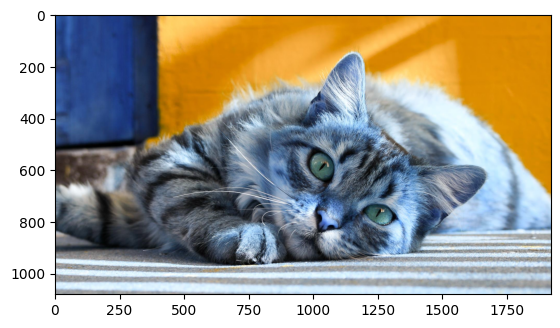

In [6]:
img = cv2.imread('/content/drive/MyDrive/DL_pytorch/chap05/data/cat.jpg')
plt.imshow(img)

img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_LINEAR)
# 첫번째 파라미터, 두번째 파라미터 : 변경될 이미지크기를 (너비,높이)로 지정, interpolation : 보간법
img = ToTensor()(img).unsqueeze(0)
# 1차원 데이터를 생성하는 함수. 즉, 이미지 데이터를 텐서로 변환하고, 그 변환된 데이터를 1차원으로 변경하겠다는 의미

print(img.shape)

### (0):Conv2d 특성 맵 확인

In [7]:
result = LayerActivations(model.features, 0)  # 0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-3-fd639b924e9f>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


### 특정 맵 확인

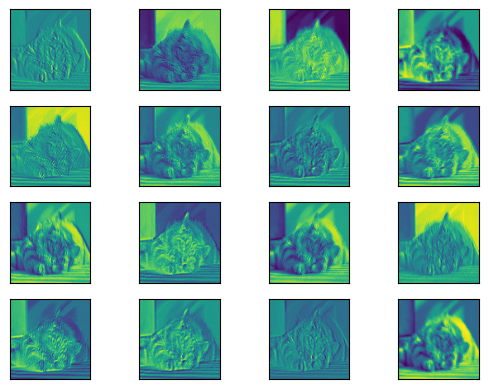

<Figure size 1200x800 with 0 Axes>

In [8]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])

plt.show()

### 20번째 계층에 대한 특성 맵

In [9]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-3-fd639b924e9f>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


### 특정 맵 확인

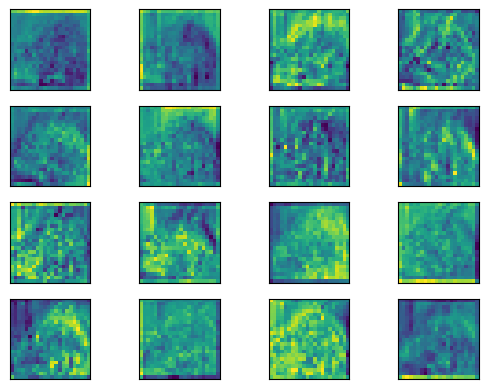

<Figure size 1200x800 with 0 Axes>

In [10]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])

plt.show()

### 40번째 계층에 대한 특성 맵

In [11]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-3-fd639b924e9f>:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


### 특성 맵 확인

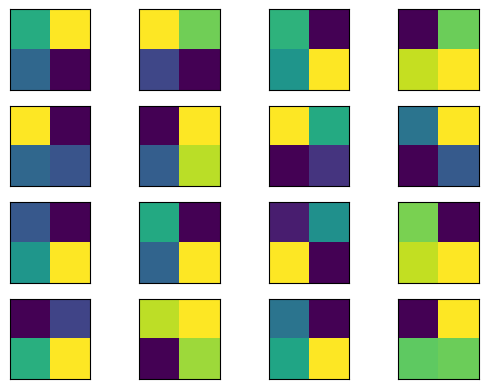

<Figure size 1200x800 with 0 Axes>

In [12]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize = (12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for row in range(4):
  for column in range(4):
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row * 10 + column])

plt.show()